# **Google Drive**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


##**GPU**

jupyter notebook --NotebookApp.allow_origin='https://colab.research.google.com' --port=4000 --NotebookApp.port_retries=0

In [2]:
!nvidia-smi

Sun Aug  4 17:04:32 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   45C    P8              11W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

# **Install**

In [3]:
!pip install torchmetrics

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl.metadata (1.8 kB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinu

# **Imports 📢**

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader, random_split
import torch.backends.cudnn as cudnn

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from torchmetrics import Accuracy
from tqdm import tqdm

import glob

# **LSTM from Scratch 🧿**

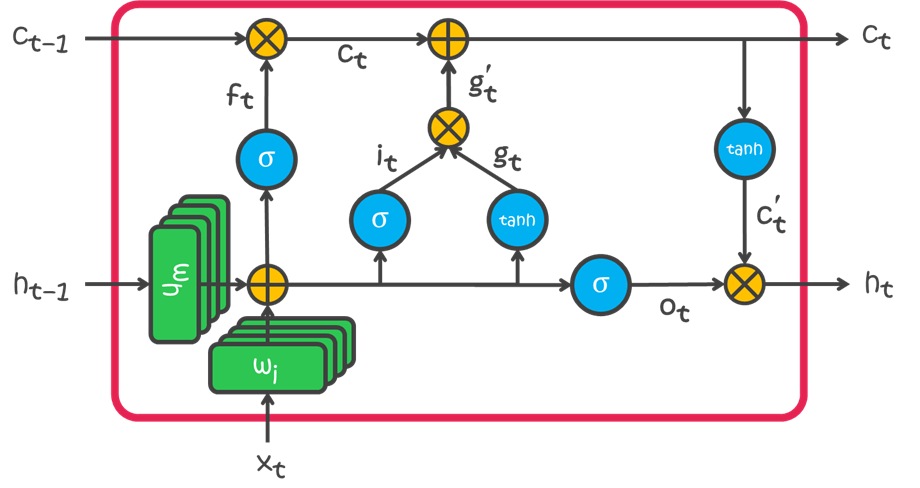

In [5]:
class Gate(nn.Module):
  def __init__(self, hidden_size, af):
    super().__init__()
    self.fc_h = nn.LazyLinear(out_features=hidden_size)
    self.fc_x = nn.LazyLinear(out_features=hidden_size)
    self.af = nn.Sigmoid() if af == 'sigmoid' else nn.Tanh()

  def forward(self, x, h):
    return self.af(self.fc_x(x) + self.fc_h(h))

In [6]:
my_gate = Gate(32, 'tanh')
my_gate(torch.randn(3, 32), torch.randn(3, 24)).shape

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


torch.Size([3, 32])

In [7]:
class LSTM(nn.Module):
  def __init__(self, hidden_size):
    super().__init__()
    self.hidden_size = hidden_size

    self.forget_gate = Gate(self.hidden_size, 'sigmoid')
    self.input_gate = Gate(self.hidden_size, 'sigmoid')
    self.output_gate = Gate(self.hidden_size, 'sigmoid')
    self.gate = Gate(self.hidden_size, 'tanh')

  def forward(self, x):
    h_t = torch.zeros(self.hidden_size)
    c_t = torch.zeros(self.hidden_size)
    output = []
    #
    for x_t in x:
      f_t = self.forget_gate(x_t, h_t)
      c_t = c_t * f_t
      #
      g_t = self.gate(x_t, h_t)
      i_t = self.input_gate(x_t, h_t)
      c_t = c_t + (i_t * g_t)
      #
      o_t = self.output_gate(x_t, h_t)
      h_t = o_t * torch.tanh(c_t)
      output.append(h_t)

    return output, h_t, c_t

In [8]:
lstm = LSTM(32)
lstm

LSTM(
  (forget_gate): Gate(
    (fc_h): LazyLinear(in_features=0, out_features=32, bias=True)
    (fc_x): LazyLinear(in_features=0, out_features=32, bias=True)
    (af): Sigmoid()
  )
  (input_gate): Gate(
    (fc_h): LazyLinear(in_features=0, out_features=32, bias=True)
    (fc_x): LazyLinear(in_features=0, out_features=32, bias=True)
    (af): Sigmoid()
  )
  (output_gate): Gate(
    (fc_h): LazyLinear(in_features=0, out_features=32, bias=True)
    (fc_x): LazyLinear(in_features=0, out_features=32, bias=True)
    (af): Sigmoid()
  )
  (gate): Gate(
    (fc_h): LazyLinear(in_features=0, out_features=32, bias=True)
    (fc_x): LazyLinear(in_features=0, out_features=32, bias=True)
    (af): Tanh()
  )
)

In [9]:
output, ht, ct = lstm(torch.randn(5, 10))

In [10]:
len(output)

5

In [11]:
output[0].shape

torch.Size([32])

# **Dataset 🗂️**

## Load dataset

In [13]:
!unzip '/content/UCI HAR Dataset.zip'

Archive:  /content/UCI HAR Dataset.zip
   creating: UCI HAR Dataset/
  inflating: UCI HAR Dataset/.DS_Store  
   creating: __MACOSX/
   creating: __MACOSX/UCI HAR Dataset/
  inflating: __MACOSX/UCI HAR Dataset/._.DS_Store  
  inflating: UCI HAR Dataset/activity_labels.txt  
  inflating: __MACOSX/UCI HAR Dataset/._activity_labels.txt  
  inflating: UCI HAR Dataset/features.txt  
  inflating: __MACOSX/UCI HAR Dataset/._features.txt  
  inflating: UCI HAR Dataset/features_info.txt  
  inflating: __MACOSX/UCI HAR Dataset/._features_info.txt  
  inflating: UCI HAR Dataset/README.txt  
  inflating: __MACOSX/UCI HAR Dataset/._README.txt  
   creating: UCI HAR Dataset/test/
   creating: UCI HAR Dataset/test/Inertial Signals/
  inflating: UCI HAR Dataset/test/Inertial Signals/body_acc_x_test.txt  
   creating: __MACOSX/UCI HAR Dataset/test/
   creating: __MACOSX/UCI HAR Dataset/test/Inertial Signals/
  inflating: __MACOSX/UCI HAR Dataset/test/Inertial Signals/._body_acc_x_test.txt  
  inflating

In [14]:
import os
os.listdir('/content/UCI HAR Dataset/train/Inertial Signals')

['total_acc_y_train.txt',
 'total_acc_x_train.txt',
 'total_acc_z_train.txt',
 'body_gyro_y_train.txt',
 'body_gyro_x_train.txt',
 'body_gyro_z_train.txt',
 'body_acc_x_train.txt',
 'body_acc_z_train.txt',
 'body_acc_y_train.txt']

In [15]:
train_data = []
for file in glob.glob('/content/UCI HAR Dataset/train/Inertial Signals/*'):
  train_data.append(np.loadtxt(file))

In [16]:
torch.tensor(train_data).permute(1, 2, 0).shape

<ipython-input-16-0e40b4e7718b>:1: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:274.)
  torch.tensor(train_data).permute(1, 2, 0).shape


torch.Size([7352, 128, 9])

In [90]:
def har_dataset(phase):
  x = []
  data_dir = f'/content/UCI HAR Dataset/{phase}/Inertial Signals/*'
  lis = glob.glob(data_dir)
  lis.sort()
  for file_dir in lis:
    x.append(np.loadtxt(file_dir))
  y = np.loadtxt(f'/content/UCI HAR Dataset/{phase}/y_{phase}.txt')
  #
  x = torch.FloatTensor(x).permute(1, 2, 0)
  y = torch.LongTensor(y) - 1
  return x, y

In [91]:
x_train, y_train = har_dataset('train')
x_test, y_test = har_dataset('test')

In [92]:
x_train.shape, y_train.shape

(torch.Size([7352, 128, 9]), torch.Size([7352]))

In [93]:
x_test.shape, y_test.shape

(torch.Size([2947, 128, 9]), torch.Size([2947]))

In [94]:
y_train

tensor([4, 4, 4,  ..., 1, 1, 1])

In [95]:
torch.unique(y_train)

tensor([0, 1, 2, 3, 4, 5])

## TensorDataset

In [96]:
train_set = TensorDataset(x_train, y_train)
test_set = TensorDataset(x_test, y_test)

## DataLoader

In [97]:
train_loader = DataLoader(train_set, batch_size=256, shuffle=True)
test_loader = DataLoader(test_set, batch_size=256, shuffle=False)

In [98]:
x, y = next(iter(train_loader))
print(x.shape)
print(y.shape)

torch.Size([256, 128, 9])
torch.Size([256])


## Visulaize

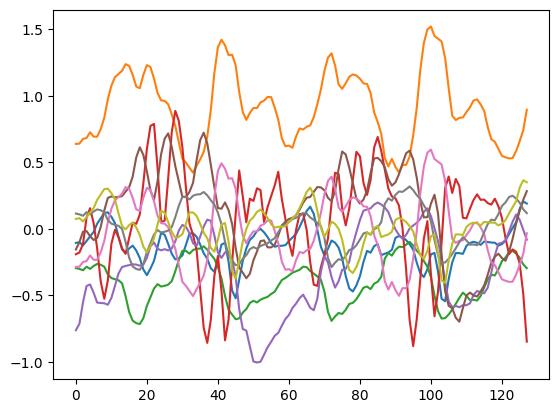

In [26]:
plt.plot(x[0]);

# **Model 🧠**

## RNN

In [27]:
class RNNModel(nn.Module):
  def __init__(self, RNN, input_size, hidden_size, num_layers, bidirectional, num_cls):
    super().__init__()
    self.rnn = RNN(input_size=input_size,
                      hidden_size=hidden_size,
                      num_layers=num_layers,
                      bidirectional=bidirectional,
                      batch_first=True)
    self.fc = nn.LazyLinear(num_cls)

  def forward(self, x):
    outputs, _ = self.rnn(x)
    y = self.fc(outputs) # out: many[:, -1, :]
    y = y.mean(dim=1)
    return y

In [28]:
model = RNNModel(nn.LSTM, 9, 32, 1, False, 6)
model

RNNModel(
  (rnn): LSTM(9, 32, batch_first=True)
  (fc): LazyLinear(in_features=0, out_features=6, bias=True)
)

In [29]:
x.shape

torch.Size([256, 128, 9])

In [30]:
model(x).shape

torch.Size([256, 6])

## CNN

In [31]:
conv1 = nn.Conv1d(9, 32, 3)
conv1.weight.shape

torch.Size([32, 9, 3])

In [32]:
x.shape

torch.Size([256, 128, 9])

In [33]:
conv1(x.permute(0, 2, 1)).shape

torch.Size([256, 32, 126])

In [34]:
class CNNModel(nn.Module):

  def __init__(self, num_filters, kernel_size, num_cls):
    super().__init__()

    self.conv1 = nn.LazyConv1d(num_filters[0], kernel_size[0], padding=1)
    self.bn1 = nn.BatchNorm1d(num_filters[0])

    self.conv2 = nn.LazyConv1d(num_filters[1], kernel_size[1], padding=1)
    self.bn2 = nn.BatchNorm1d(num_filters[1])

    self.pool = nn.MaxPool1d(2, 2)

    self.fc = nn.LazyLinear(num_cls)


  def forward(self, x):
    x = x.permute(0, 2, 1)
    #
    y = self.bn1(self.conv1(x)).relu()
    y = self.bn2(self.conv2(y)).relu()
    #
    y = self.pool(y)
    y = y.flatten(1)
    return self.fc(y)

In [35]:
model = CNNModel([64, 64], [3, 3], 6)
model

CNNModel(
  (conv1): LazyConv1d(0, 64, kernel_size=(3,), stride=(1,), padding=(1,))
  (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): LazyConv1d(0, 64, kernel_size=(3,), stride=(1,), padding=(1,))
  (bn2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc): LazyLinear(in_features=0, out_features=6, bias=True)
)

In [36]:
model(x).shape

torch.Size([256, 6])

In [37]:
64*64*6

24576

## CNN-LSTM

In [38]:
class CNNLSTM(nn.Module):
  def __init__(self, input_size, cnn_hidden_size, rnn_hidden_size, num_layers, num_cls):
    super().__init__()

    self.conv1 = nn.Conv1d(input_size, cnn_hidden_size, kernel_size=5, padding=1)
    self.bn1 = nn.BatchNorm1d(cnn_hidden_size)

    self.conv2 = nn.Conv1d(cnn_hidden_size, cnn_hidden_size, kernel_size=5, padding=1)
    self.bn2 = nn.BatchNorm1d(cnn_hidden_size)

    self.pool = nn.MaxPool1d(2, 2)

    self.lstm = nn.LSTM(cnn_hidden_size, rnn_hidden_size, num_layers, batch_first=True)

    self.fc = nn.LazyLinear(num_cls)

  def forward(self, x):
    x = x.permute(0, 2, 1)
    y = self.bn1(self.conv1(x)).relu()
    y = self.bn2(self.conv2(y)).relu()
    # y = self.pool(y)

    y = y.permute(0, 2, 1)
    y, _ = self.lstm(y)
    y = self.fc(y)
    return y.mean(dim=1)

In [39]:
model = CNNLSTM(9, 32, 128, 3, 6)
model

CNNLSTM(
  (conv1): Conv1d(9, 32, kernel_size=(5,), stride=(1,), padding=(1,))
  (bn1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv1d(32, 32, kernel_size=(5,), stride=(1,), padding=(1,))
  (bn2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (lstm): LSTM(32, 128, num_layers=3, batch_first=True)
  (fc): LazyLinear(in_features=0, out_features=6, bias=True)
)

In [40]:
y = model(x)
y.shape

torch.Size([256, 6])

## Params

In [41]:
def num_params(model, k=1e6):
  nums = sum(p.numel() for p in model.parameters())/k
  return nums

In [42]:
num_params(model, 1e3)

354.662

# **Device ⚙️**

In [43]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

# **Utils 🧰**

In [44]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

# **Functions** 🧮

In [53]:
def train_one_epoch(model, train_loader, loss_fn, optimizer, epoch=None):
  model.train()
  loss_train = AverageMeter()
  acc_train = Accuracy(task='multiclass', num_classes=6).to(device)
  with tqdm(train_loader, unit="batch") as tepoch:
    for inputs, targets in tepoch:
      if epoch is not None:
        tepoch.set_description(f"Epoch {epoch}")
      inputs = inputs.to(device)
      targets = targets.to(device)

      outputs = model(inputs)

      loss = loss_fn(outputs, targets)

      loss.backward()
      optimizer.step()
      optimizer.zero_grad()

      loss_train.update(loss.item())
      acc_train(outputs, targets.int())
      tepoch.set_postfix(loss=loss_train.avg,
                         accuracy=100.*acc_train.compute().item())
  return model, loss_train.avg, acc_train.compute().item()

In [71]:
def validation(model, test_loader, loss_fn):
  model.eval()
  with torch.no_grad():
    loss_valid = AverageMeter()
    acc_valid = Accuracy(task='multiclass', num_classes=6).to(device)
    for i, (inputs, targets) in enumerate(test_loader):
      inputs = inputs.to(device)
      targets = targets.to(device)

      outputs = model(inputs)
      loss = loss_fn(outputs, targets)

      loss_valid.update(loss.item())
      acc_valid(outputs, targets.int())
  return loss_valid.avg, acc_valid.compute().item()

# **Efficient way for set hyperparams 🔨**

## Step 1: check forward path

Calculate loss for one batch

In [48]:
model = RNNModel(nn.LSTM, 9, 128, 1, False, 6).to(device)
loss_fn = nn.CrossEntropyLoss()

x_batch, y_batch = next(iter(train_loader))
outputs = model(x_batch.to(device))
loss = loss_fn(outputs, y_batch.to(device))
print(loss)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


tensor(1.7884, device='cuda:0', grad_fn=<NllLossBackward0>)


## Step 2: check backward path

Select 5 random batches and train the model

In [55]:
_, mini_train_dataset = random_split(train_set, (len(train_set)-500, 500))
mini_train_loader = DataLoader(mini_train_dataset, 20)

In [56]:
model = RNNModel(nn.LSTM, 9, 128, 1, False, 6).to(device)
loss_fn = nn.CrossEntropyLoss()

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [57]:
optimizer = optim.SGD(model.parameters(), lr=0.1)

In [58]:
num_epochs = 100
for epoch in range(num_epochs):
  model, _, _ = train_one_epoch(model, mini_train_loader, loss_fn, optimizer, epoch)

Epoch 99: 100%|██████████| 25/25 [00:00<00:00, 82.28batch/s, accuracy=86.6, loss=0.354]


## Step 3: select best lr

Train all data for one epoch

In [59]:
num_epochs = 5
for lr in [0.9, 0.5, 0.2, 0.1, 0.01]:
  print(f'LR={lr}')
  model = RNNModel(nn.LSTM, 9, 128, 3, False, 6).to(device)
  optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=1e-4, momentum=0.9)
  for epoch in range(num_epochs):
    model, _, _ = train_one_epoch(model, train_loader, loss_fn, optimizer, epoch)
  print()

LR=0.9


Epoch 4: 100%|██████████| 29/29 [00:01<00:00, 24.76batch/s, accuracy=83.7, loss=0.447]



LR=0.5


Epoch 4: 100%|██████████| 29/29 [00:01<00:00, 23.56batch/s, accuracy=29.4, loss=1.62]



LR=0.2


Epoch 4: 100%|██████████| 29/29 [00:01<00:00, 24.75batch/s, accuracy=51.3, loss=1.08]



LR=0.1


Epoch 4: 100%|██████████| 29/29 [00:01<00:00, 24.00batch/s, accuracy=43.8, loss=1.23]



LR=0.01


Epoch 4: 100%|██████████| 29/29 [00:01<00:00, 24.76batch/s, accuracy=19.1, loss=1.78]


## Step 4: small grid (optional)

Create a small grid based on the WD and the best LR



In [60]:
num_epochs = 5

for lr in [0.08, 0.09, 0.1, 0.15, 0.2]:
  for wd in [1e-4, 1e-5, 0.]:
    model = RNNModel(nn.LSTM, 9, 128, 1, True, 6).to(device)
    optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=wd)
    print(f'LR={lr}, WD={wd}')

    for epoch in range(num_epochs):
      model, loss, _ = train_one_epoch(model, train_loader, loss_fn, optimizer, epoch)
    print()

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


LR=0.08, WD=0.0001


Epoch 4: 100%|██████████| 29/29 [00:00<00:00, 35.31batch/s, accuracy=39, loss=1.46]



LR=0.08, WD=1e-05


Epoch 4: 100%|██████████| 29/29 [00:00<00:00, 36.45batch/s, accuracy=38.5, loss=1.51]



LR=0.08, WD=0.0


Epoch 4: 100%|██████████| 29/29 [00:00<00:00, 35.94batch/s, accuracy=37.7, loss=1.54]



LR=0.09, WD=0.0001


Epoch 4: 100%|██████████| 29/29 [00:00<00:00, 35.31batch/s, accuracy=37.9, loss=1.49]



LR=0.09, WD=1e-05


Epoch 4: 100%|██████████| 29/29 [00:00<00:00, 31.50batch/s, accuracy=40.7, loss=1.44]



LR=0.09, WD=0.0


Epoch 4: 100%|██████████| 29/29 [00:00<00:00, 35.53batch/s, accuracy=40, loss=1.44]



LR=0.1, WD=0.0001


Epoch 4: 100%|██████████| 29/29 [00:00<00:00, 35.20batch/s, accuracy=40.1, loss=1.38]



LR=0.1, WD=1e-05


Epoch 4: 100%|██████████| 29/29 [00:00<00:00, 32.66batch/s, accuracy=39.1, loss=1.41]



LR=0.1, WD=0.0


Epoch 4: 100%|██████████| 29/29 [00:00<00:00, 34.53batch/s, accuracy=41.5, loss=1.37]



LR=0.15, WD=0.0001


Epoch 4: 100%|██████████| 29/29 [00:00<00:00, 34.58batch/s, accuracy=44.8, loss=1.27]



LR=0.15, WD=1e-05


Epoch 4: 100%|██████████| 29/29 [00:00<00:00, 31.19batch/s, accuracy=44.3, loss=1.28]



LR=0.15, WD=0.0


Epoch 4: 100%|██████████| 29/29 [00:00<00:00, 34.98batch/s, accuracy=44.6, loss=1.28]



LR=0.2, WD=0.0001


Epoch 4: 100%|██████████| 29/29 [00:00<00:00, 35.25batch/s, accuracy=47.5, loss=1.22]



LR=0.2, WD=1e-05


Epoch 4: 100%|██████████| 29/29 [00:00<00:00, 34.37batch/s, accuracy=49, loss=1.19]



LR=0.2, WD=0.0


Epoch 4: 100%|██████████| 29/29 [00:00<00:00, 33.11batch/s, accuracy=45.7, loss=1.21]

## Step 5: train more epochs

In [105]:
model = RNNModel(nn.LSTM, 9, 128, 3, False, 6).to(device)

In [110]:
model = CNNModel([32, 32], [5, 5], 6).to(device)

In [120]:
model = CNNLSTM(9, 32, 128, 3, 6).to(device)

In [121]:
lr = 0.1
wd = 1e-4
optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=wd, momentum=0.9)

loss_fn = nn.CrossEntropyLoss()

In [122]:
loss_train_hist = []
loss_valid_hist = []

acc_train_hist = []
acc_valid_hist = []

best_loss_valid = torch.inf
epoch_counter = 0

In [123]:
num_epochs = 80

for epoch in range(num_epochs):
  # Train
  model, loss_train, acc_train = train_one_epoch(model,
                                                 train_loader,
                                                 loss_fn,
                                                 optimizer,
                                                 epoch)
  # Validation
  loss_valid, acc_valid = validation(model,
                                     test_loader,
                                     loss_fn)

  loss_train_hist.append(loss_train)
  loss_valid_hist.append(loss_valid)

  acc_train_hist.append(acc_train)
  acc_valid_hist.append(acc_valid)

  print(f'Valid: Loss = {loss_valid:.4}, Acc = {acc_valid:.4}')

  if loss_valid < best_loss_valid:
    torch.save(model, 'model-cnn-lstm.pt')
    best_loss_valid = loss_valid
    print('Model Saved!')

  print()
  epoch_counter += 1

Epoch 0: 100%|██████████| 29/29 [00:01<00:00, 22.50batch/s, accuracy=31.6, loss=1.76]


Valid: Loss = 1.687, Acc = 0.3505
Model Saved!



Epoch 1: 100%|██████████| 29/29 [00:01<00:00, 24.17batch/s, accuracy=55.7, loss=1.04]


Valid: Loss = 0.78, Acc = 0.64
Model Saved!



Epoch 2: 100%|██████████| 29/29 [00:01<00:00, 23.83batch/s, accuracy=70.7, loss=0.608]


Valid: Loss = 1.146, Acc = 0.5813



Epoch 3: 100%|██████████| 29/29 [00:01<00:00, 23.80batch/s, accuracy=81.3, loss=0.45]


Valid: Loss = 0.6802, Acc = 0.7662
Model Saved!



Epoch 4: 100%|██████████| 29/29 [00:01<00:00, 23.57batch/s, accuracy=87, loss=0.335]


Valid: Loss = 0.4553, Acc = 0.8276
Model Saved!



Epoch 5: 100%|██████████| 29/29 [00:01<00:00, 22.45batch/s, accuracy=91.1, loss=0.238]


Valid: Loss = 0.5936, Acc = 0.8453



Epoch 6: 100%|██████████| 29/29 [00:01<00:00, 22.86batch/s, accuracy=92.4, loss=0.214]


Valid: Loss = 0.5133, Acc = 0.8005



Epoch 7: 100%|██████████| 29/29 [00:01<00:00, 23.19batch/s, accuracy=93.8, loss=0.169]


Valid: Loss = 0.3469, Acc = 0.8911
Model Saved!



Epoch 8: 100%|██████████| 29/29 [00:01<00:00, 23.74batch/s, accuracy=94.2, loss=0.153]


Valid: Loss = 0.4163, Acc = 0.8907



Epoch 9: 100%|██████████| 29/29 [00:01<00:00, 23.69batch/s, accuracy=94.9, loss=0.137]


Valid: Loss = 0.4299, Acc = 0.8738



Epoch 10: 100%|██████████| 29/29 [00:01<00:00, 23.87batch/s, accuracy=93.4, loss=0.179]


Valid: Loss = 0.5831, Acc = 0.8694



Epoch 11: 100%|██████████| 29/29 [00:01<00:00, 23.58batch/s, accuracy=94.7, loss=0.135]


Valid: Loss = 0.464, Acc = 0.8935



Epoch 12: 100%|██████████| 29/29 [00:01<00:00, 23.15batch/s, accuracy=95.2, loss=0.126]


Valid: Loss = 0.3904, Acc = 0.8968



Epoch 13: 100%|██████████| 29/29 [00:01<00:00, 20.65batch/s, accuracy=95.3, loss=0.12]


Valid: Loss = 0.4954, Acc = 0.8599



Epoch 14: 100%|██████████| 29/29 [00:01<00:00, 21.20batch/s, accuracy=94.4, loss=0.134]


Valid: Loss = 0.3303, Acc = 0.8958
Model Saved!



Epoch 15: 100%|██████████| 29/29 [00:01<00:00, 21.31batch/s, accuracy=95.4, loss=0.116]


Valid: Loss = 0.3877, Acc = 0.8884



Epoch 16: 100%|██████████| 29/29 [00:01<00:00, 23.05batch/s, accuracy=95, loss=0.112]


Valid: Loss = 0.3639, Acc = 0.8873



Epoch 17: 100%|██████████| 29/29 [00:01<00:00, 22.89batch/s, accuracy=95.4, loss=0.105]


Valid: Loss = 0.3961, Acc = 0.8914



Epoch 18: 100%|██████████| 29/29 [00:01<00:00, 22.73batch/s, accuracy=95.1, loss=0.114]


Valid: Loss = 0.355, Acc = 0.903



Epoch 19: 100%|██████████| 29/29 [00:01<00:00, 23.25batch/s, accuracy=95.4, loss=0.108]


Valid: Loss = 0.4029, Acc = 0.8863



Epoch 20: 100%|██████████| 29/29 [00:01<00:00, 22.98batch/s, accuracy=95.2, loss=0.111]


Valid: Loss = 0.6834, Acc = 0.8836



Epoch 21: 100%|██████████| 29/29 [00:01<00:00, 23.19batch/s, accuracy=95.1, loss=0.115]


Valid: Loss = 0.6257, Acc = 0.8914



Epoch 22: 100%|██████████| 29/29 [00:01<00:00, 22.99batch/s, accuracy=95.2, loss=0.117]


Valid: Loss = 0.5022, Acc = 0.8975



Epoch 23: 100%|██████████| 29/29 [00:01<00:00, 21.72batch/s, accuracy=95.2, loss=0.112]


Valid: Loss = 0.6738, Acc = 0.9046



Epoch 24: 100%|██████████| 29/29 [00:01<00:00, 21.55batch/s, accuracy=95.3, loss=0.106]


Valid: Loss = 0.6245, Acc = 0.8863



Epoch 25: 100%|██████████| 29/29 [00:01<00:00, 23.44batch/s, accuracy=94.8, loss=0.126]


Valid: Loss = 0.6801, Acc = 0.8785



Epoch 26: 100%|██████████| 29/29 [00:01<00:00, 23.35batch/s, accuracy=95.2, loss=0.113]


Valid: Loss = 0.6698, Acc = 0.8616



Epoch 27: 100%|██████████| 29/29 [00:01<00:00, 23.30batch/s, accuracy=95, loss=0.114]


Valid: Loss = 0.4254, Acc = 0.8782



Epoch 28: 100%|██████████| 29/29 [00:01<00:00, 23.56batch/s, accuracy=94.9, loss=0.111]


Valid: Loss = 0.4385, Acc = 0.9091



Epoch 29: 100%|██████████| 29/29 [00:01<00:00, 23.72batch/s, accuracy=95.3, loss=0.106]


Valid: Loss = 0.4556, Acc = 0.8992



Epoch 30: 100%|██████████| 29/29 [00:01<00:00, 23.69batch/s, accuracy=95.8, loss=0.102]


Valid: Loss = 0.3162, Acc = 0.8958
Model Saved!



Epoch 31: 100%|██████████| 29/29 [00:01<00:00, 23.08batch/s, accuracy=95.8, loss=0.0982]


Valid: Loss = 0.3642, Acc = 0.8982



Epoch 32: 100%|██████████| 29/29 [00:01<00:00, 22.31batch/s, accuracy=95.6, loss=0.102]


Valid: Loss = 0.4325, Acc = 0.9046



Epoch 33: 100%|██████████| 29/29 [00:01<00:00, 22.74batch/s, accuracy=95.9, loss=0.0986]


Valid: Loss = 0.3453, Acc = 0.8982



Epoch 34: 100%|██████████| 29/29 [00:01<00:00, 23.02batch/s, accuracy=95.6, loss=0.0982]


Valid: Loss = 0.4061, Acc = 0.9006



Epoch 35: 100%|██████████| 29/29 [00:01<00:00, 23.83batch/s, accuracy=95.4, loss=0.109]


Valid: Loss = 0.484, Acc = 0.9023



Epoch 36: 100%|██████████| 29/29 [00:01<00:00, 23.77batch/s, accuracy=95.7, loss=0.101]


Valid: Loss = 0.5629, Acc = 0.8911



Epoch 37: 100%|██████████| 29/29 [00:01<00:00, 23.76batch/s, accuracy=95.7, loss=0.0951]


Valid: Loss = 0.5337, Acc = 0.8717



Epoch 38: 100%|██████████| 29/29 [00:01<00:00, 23.35batch/s, accuracy=95.6, loss=0.0963]


Valid: Loss = 0.7188, Acc = 0.8873



Epoch 39: 100%|██████████| 29/29 [00:01<00:00, 23.65batch/s, accuracy=95.7, loss=0.0949]


Valid: Loss = 0.7005, Acc = 0.8921



Epoch 40: 100%|██████████| 29/29 [00:01<00:00, 24.02batch/s, accuracy=95.4, loss=0.105]


Valid: Loss = 1.016, Acc = 0.7648



Epoch 41: 100%|██████████| 29/29 [00:01<00:00, 22.96batch/s, accuracy=94.7, loss=0.127]


Valid: Loss = 0.7026, Acc = 0.8873



Epoch 42: 100%|██████████| 29/29 [00:01<00:00, 22.61batch/s, accuracy=94.8, loss=0.126]


Valid: Loss = 1.156, Acc = 0.8276



Epoch 43: 100%|██████████| 29/29 [00:01<00:00, 22.26batch/s, accuracy=93.1, loss=0.167]


Valid: Loss = 0.5198, Acc = 0.9013



Epoch 44: 100%|██████████| 29/29 [00:01<00:00, 23.83batch/s, accuracy=95.4, loss=0.111]


Valid: Loss = 0.3975, Acc = 0.887



Epoch 45: 100%|██████████| 29/29 [00:01<00:00, 23.79batch/s, accuracy=95.6, loss=0.103]


Valid: Loss = 0.4883, Acc = 0.8951



Epoch 46: 100%|██████████| 29/29 [00:01<00:00, 23.54batch/s, accuracy=95.6, loss=0.0984]


Valid: Loss = 0.4704, Acc = 0.8928



Epoch 47: 100%|██████████| 29/29 [00:01<00:00, 24.05batch/s, accuracy=95.6, loss=0.101]


Valid: Loss = 0.4552, Acc = 0.8806



Epoch 48: 100%|██████████| 29/29 [00:01<00:00, 23.89batch/s, accuracy=95.4, loss=0.108]


Valid: Loss = 0.4954, Acc = 0.8985



Epoch 49: 100%|██████████| 29/29 [00:01<00:00, 23.75batch/s, accuracy=95.7, loss=0.0995]


Valid: Loss = 0.4211, Acc = 0.9091



Epoch 50: 100%|██████████| 29/29 [00:01<00:00, 23.20batch/s, accuracy=95.6, loss=0.0974]


Valid: Loss = 0.3844, Acc = 0.9019



Epoch 51: 100%|██████████| 29/29 [00:01<00:00, 19.37batch/s, accuracy=95.4, loss=0.102]


Valid: Loss = 0.4397, Acc = 0.8921



Epoch 52: 100%|██████████| 29/29 [00:01<00:00, 21.94batch/s, accuracy=95.3, loss=0.101]


Valid: Loss = 0.3607, Acc = 0.9023



Epoch 53: 100%|██████████| 29/29 [00:01<00:00, 23.76batch/s, accuracy=95.5, loss=0.098]


Valid: Loss = 0.3471, Acc = 0.9104



Epoch 54: 100%|██████████| 29/29 [00:01<00:00, 23.03batch/s, accuracy=95.7, loss=0.0967]


Valid: Loss = 0.3643, Acc = 0.8914



Epoch 55: 100%|██████████| 29/29 [00:01<00:00, 23.56batch/s, accuracy=95.7, loss=0.0931]


Valid: Loss = 0.3616, Acc = 0.9094



Epoch 56: 100%|██████████| 29/29 [00:01<00:00, 23.42batch/s, accuracy=95.3, loss=0.105]


Valid: Loss = 0.4771, Acc = 0.8999



Epoch 57: 100%|██████████| 29/29 [00:01<00:00, 23.81batch/s, accuracy=95.7, loss=0.0965]


Valid: Loss = 0.4481, Acc = 0.906



Epoch 58: 100%|██████████| 29/29 [00:01<00:00, 23.35batch/s, accuracy=95.5, loss=0.096]


Valid: Loss = 0.3419, Acc = 0.9013



Epoch 59: 100%|██████████| 29/29 [00:01<00:00, 23.19batch/s, accuracy=95.7, loss=0.1]


Valid: Loss = 0.502, Acc = 0.905



Epoch 60: 100%|██████████| 29/29 [00:01<00:00, 22.26batch/s, accuracy=95.6, loss=0.0965]


Valid: Loss = 0.4272, Acc = 0.888



Epoch 61: 100%|██████████| 29/29 [00:01<00:00, 21.84batch/s, accuracy=95.4, loss=0.106]


Valid: Loss = 0.4391, Acc = 0.9108



Epoch 62: 100%|██████████| 29/29 [00:01<00:00, 23.43batch/s, accuracy=95.4, loss=0.111]


Valid: Loss = 0.4847, Acc = 0.8972



Epoch 63: 100%|██████████| 29/29 [00:01<00:00, 23.44batch/s, accuracy=95.5, loss=0.103]


Valid: Loss = 0.5082, Acc = 0.908



Epoch 64: 100%|██████████| 29/29 [00:01<00:00, 23.62batch/s, accuracy=95.9, loss=0.0967]


Valid: Loss = 0.4805, Acc = 0.9091



Epoch 65: 100%|██████████| 29/29 [00:01<00:00, 23.61batch/s, accuracy=96, loss=0.0946]


Valid: Loss = 0.47, Acc = 0.8819



Epoch 66: 100%|██████████| 29/29 [00:01<00:00, 23.64batch/s, accuracy=95.7, loss=0.0956]


Valid: Loss = 0.5354, Acc = 0.9013



Epoch 67: 100%|██████████| 29/29 [00:01<00:00, 23.42batch/s, accuracy=95.8, loss=0.09]


Valid: Loss = 0.3342, Acc = 0.8972



Epoch 68: 100%|██████████| 29/29 [00:01<00:00, 23.18batch/s, accuracy=95.9, loss=0.0892]


Valid: Loss = 0.3583, Acc = 0.9057



Epoch 69: 100%|██████████| 29/29 [00:01<00:00, 22.17batch/s, accuracy=95.9, loss=0.0959]


Valid: Loss = 0.3704, Acc = 0.9125



Epoch 70: 100%|██████████| 29/29 [00:01<00:00, 21.74batch/s, accuracy=95.9, loss=0.0951]


Valid: Loss = 0.3239, Acc = 0.9063



Epoch 71: 100%|██████████| 29/29 [00:01<00:00, 22.64batch/s, accuracy=95.7, loss=0.101]


Valid: Loss = 0.4057, Acc = 0.9053



Epoch 72: 100%|██████████| 29/29 [00:01<00:00, 23.08batch/s, accuracy=95.9, loss=0.0894]


Valid: Loss = 0.3046, Acc = 0.9046
Model Saved!



Epoch 73: 100%|██████████| 29/29 [00:01<00:00, 23.52batch/s, accuracy=95.9, loss=0.0889]


Valid: Loss = 0.3776, Acc = 0.9094



Epoch 74: 100%|██████████| 29/29 [00:01<00:00, 23.27batch/s, accuracy=95.9, loss=0.0886]


Valid: Loss = 0.3358, Acc = 0.8982



Epoch 75: 100%|██████████| 29/29 [00:01<00:00, 23.23batch/s, accuracy=95.9, loss=0.0898]


Valid: Loss = 0.5014, Acc = 0.905



Epoch 76: 100%|██████████| 29/29 [00:01<00:00, 23.01batch/s, accuracy=95.5, loss=0.111]


Valid: Loss = 0.5641, Acc = 0.8867



Epoch 77: 100%|██████████| 29/29 [00:01<00:00, 23.01batch/s, accuracy=94.8, loss=0.126]


Valid: Loss = 0.5231, Acc = 0.8809



Epoch 78: 100%|██████████| 29/29 [00:01<00:00, 21.86batch/s, accuracy=95.3, loss=0.114]


Valid: Loss = 0.2884, Acc = 0.9013
Model Saved!



Epoch 79: 100%|██████████| 29/29 [00:01<00:00, 22.64batch/s, accuracy=95.3, loss=0.109]


Valid: Loss = 0.4265, Acc = 0.8738



# **Plot**

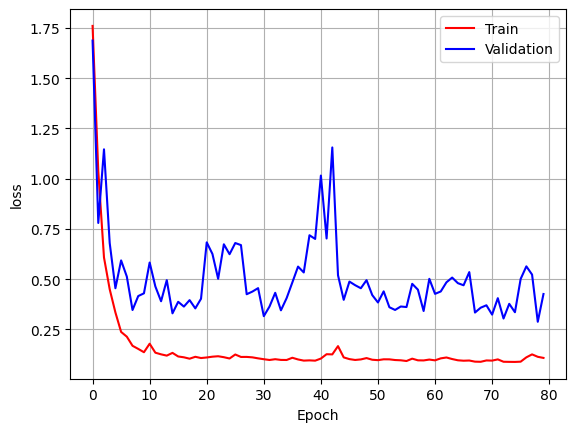

In [124]:
plt.plot(range(epoch_counter), loss_train_hist, 'r-', label='Train')
plt.plot(range(epoch_counter), loss_valid_hist, 'b-', label='Validation')

plt.xlabel('Epoch')
plt.ylabel('loss')
plt.grid(True)
plt.legend()

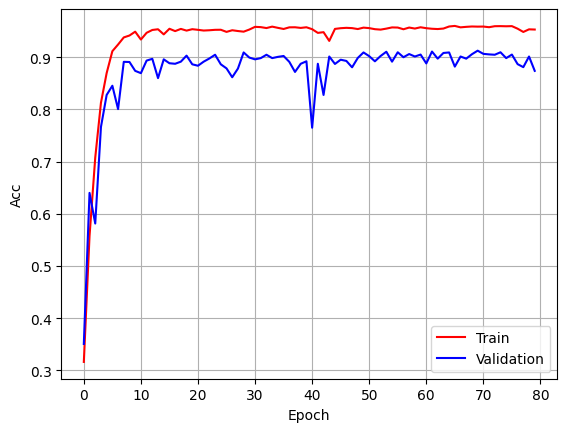

In [125]:
plt.plot(range(epoch_counter), acc_train_hist, 'r-', label='Train')
plt.plot(range(epoch_counter), acc_valid_hist, 'b-', label='Validation')

plt.xlabel('Epoch')
plt.ylabel('Acc')
plt.grid(True)
plt.legend()